In [197]:
using Images
using HDF5
include("./MKR_functions.jl")
using .MKR_functions
include("./Kernels.jl")
using .Kernels
using DSP

In [2]:
save_path = "/SaveSpot/FakeBee2/"
width = 2028 #3040 RAW data rn
height =  1520# 4056

1520

In [3]:
function GetData(path)
    img = permutedims(Images.channelview(Images.load(path))[1:3,:,:], (2,3,1))
    img = img/typemax(eltype(img))
    return img
end

GetData (generic function with 1 method)

In [4]:
img1_p = "$(save_path)Focused_y=24785_z=17914_e=32000.png"
img1 = GetData(img1_p)
img2_p = "$(save_path)Focused_y=24785_z=0_e=32000.png"
img2 = GetData(img2_p);

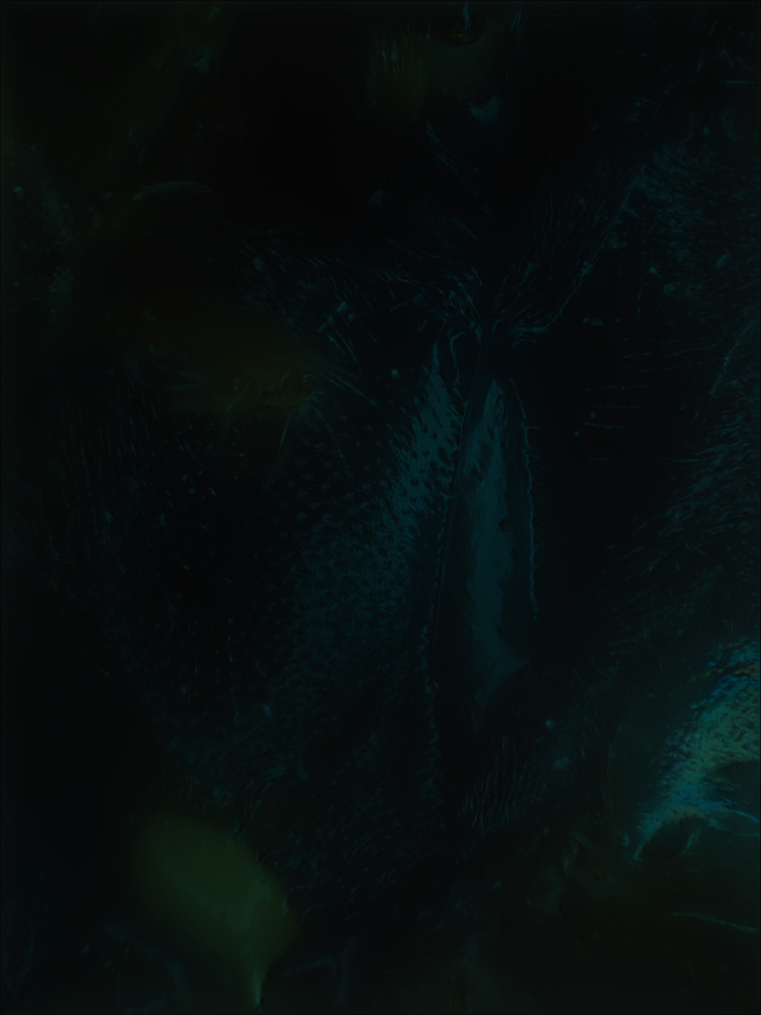

In [5]:
using IJulia
IJulia.display(Images.load(img1_p))

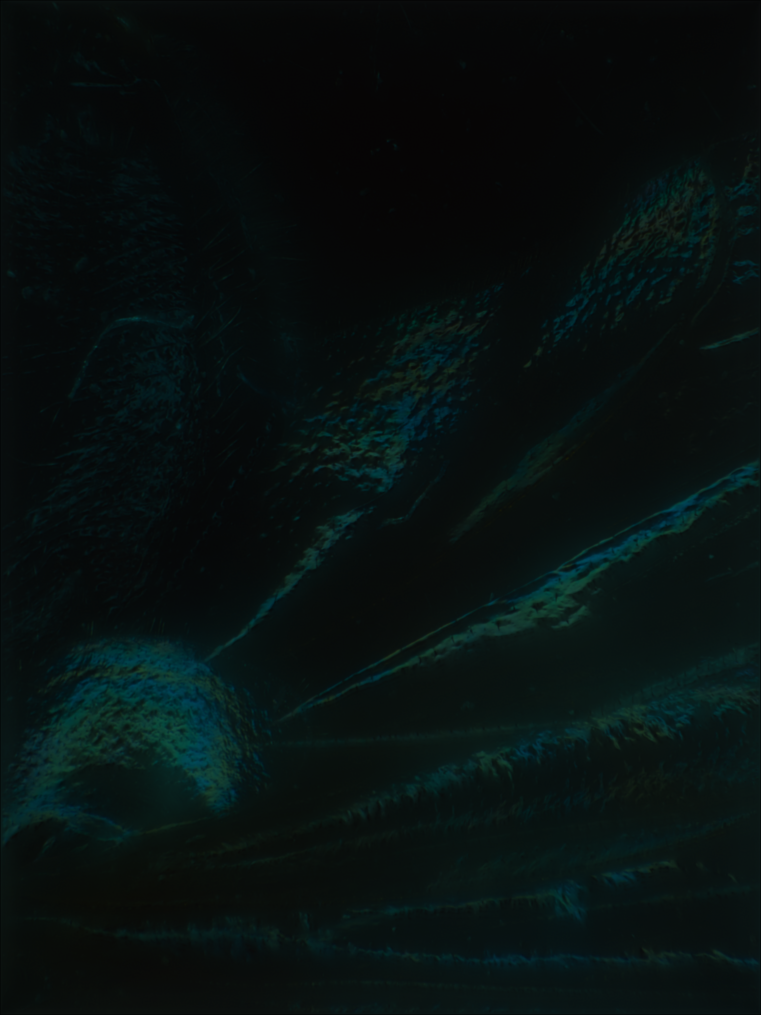

In [6]:
IJulia.display(Images.load(img2_p))

In [93]:
w,h, c = size(img1)
"""
We expect the images to be aligned somewhere around
68,-9 shift of img2 relative to img1 
"""
overlap = 0.2
res = zeros(110,3)
indx = 1
for i in 60:70#-68-10:-58#+10 # 68
    for j in -14:-5#-9-10:1 # -9
        # Left right alignment
        overlap_w = w
        overlap_h = round(Int, h * overlap)
        if j >= 0
            r1_y_s = h - overlap_h + 1 -  j
            r1_y_e = h
            r2_y_s = 1
            r2_y_e = overlap_h - j
        else
            r1_y_s = h - overlap_h + 1
            r1_y_e = h + j
            r2_y_s = 1 - j
            r2_y_e = overlap_h
        end
        if i >= 0
            r1_x_s = 1 + i
            r1_x_e = w
            r2_x_s = 1
            r2_x_e = w - i
        else 
            r1_x_s = 1
            r1_x_e = w + i
            r2_x_s = 1 - i
            r2_x_e = w
        end

        # We now have the basic indeces, we proceed to make sure the images are the same size
        # First we compute the minimum regions size
        r_w = min(r1_x_e - r1_x_s + 1, r2_x_e - r2_x_s + 1)
        r_h = min(r1_y_e - r1_y_s + 1, r2_y_e - r2_y_s + 1)
        #println("Region Size")
        #println("($(r_w), $(r_h))")
        # We now take these to generate the new endpoints
        r1_x_e = r1_x_s + r_w - 1
        r2_x_e = r2_x_s + r_w - 1
        r1_y_e = r1_y_s + r_h - 1
        r2_y_e = r2_y_s + r_h - 1

        tmp1 = img1[r1_x_s:r1_x_e, r1_y_s:r1_y_e, :] 
        tmp2 = img2[r2_x_s:r2_x_e, r2_y_s:r2_y_e, :]

        res[indx,:] = [sum(tmp1-tmp2), i, j]
        indx += 1
    end
end

In [8]:
indx = argmin((res)[:,1])
res[indx,:]

3-element Vector{Float64}:
 370320.60784313723
     60.0
    -14.0

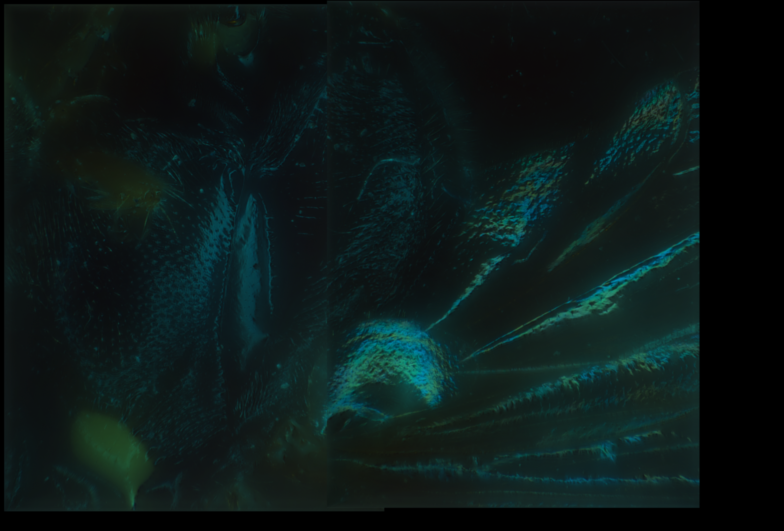

In [9]:
# Now lets see if this is correct
score, j, i = trunc.(Int, res[indx,:])

farr = zeros((w+90,2*h+90, 3))

start = 15
rem_border = 15
farr[start:start-1+w, start:start-1+h, 1:end] = img1
farr[start+i:start-1+i+w, start+j+trunc(Int,(1-overlap)*h)+rem_border:start-1+j+trunc(Int,(2-overlap)*h)-rem_border, 1:end] = img2[1:end, 1+rem_border:end-rem_border,:]

farr= permutedims(farr .* 2, (3,1,2))
farr = Images.colorview(Images.RGB,farr)

IJulia.display(farr)

In [460]:
using Statistics
function FindImageShift(img1, img2, index, overlap; iter_range=50, center_shift=(0, 0),subsampling=1)
    """
    Finds shift between img1 and img2 by iterating from -iter_range to +iter_range in both dimensions, centred around `center_shift`,
    and selecting for the one with the smallest square difference.
    for index == "i": img1 is on the left, img2 is on the right (horizontal alignment)
    for index == "j": img1 is on the top, img2 is on the bottom (vertical alignment)

    overlap :: fraction of overlap
    center_shift :: (center_i, center_j), where center_i and center_j are the shifts for the i and j directions respectively.


    Using This directly on the image does not work

    Applied to Lap and Gaussian levels this also does not work as the frequency domains are surprisingly different on every level
    """
    if iseven(subsampling)
        throw("Subsampling must be odd")
    end
    height, width, c = size(img1)  # Corrected for width-height exchange
    score = Inf
    shift = (0, 0)
    # take image derivative matched to subsample
    if subsampling >= 9
        filter =    [
                    1  1  1  1  -8  1  1  1  1;
                    1  1  1  -8  20 -8  1  1  1;
                    1  1  -8  20 -48 20 -8  1  1;
                    1 -8  20 -48 96 -48 20 -8  1;
                    -8 20 -48 96 -200 96 -48 20 -8;
                    1 -8  20 -48 96 -48 20 -8  1;
                    1  1  -8  20 -48 20 -8  1  1;
                    1  1  1  -8  20 -8  1  1  1;
                    1  1  1  1  -8  1  1  1  1
                    ]
    elseif subsampling >=7
        filter =    [
                    0  0  1  1  1  0  0;
                    0  1  1  1  1  1  0;
                    1  1  1  1  1  1  1;
                    1  1  1 -48 1  1  1;
                    1  1  1  1  1  1  1;
                    0  1  1  1  1  1  0;
                    0  0  1  1  1  0  0
                    ]
    elseif subsampling >=5
        filter =    [
                    0   1   2   1   0;
                    1   0  -2   0   1;
                    2  -2  -8  -2   2;
                    1   0  -2   0   1;
                    0   1   2   1   0
                    ]
    elseif subsampling >= 1
        filter =    [
                    1  1  1;
                    1 -8  1;
                    1  1  1
                    ]
    end
    if subsampling >= 1
        fe = trunc(Int,size(filter)[1]/2)
        img1 = abs.(DSP.conv(filter ,img1)[1+fe:end-fe, 1+fe:end-fe,:])
        img2 = abs.(DSP.conv(filter ,img2)[1+fe:end-fe, 1+fe:end-fe,:])
    end
    img1 = Statistics.mean( img1, dims = 3)
    img2 = Statistics.mean( img2, dims = 3)
    # and rescale
    max_ = maximum([img1 ; img2])
    min_ = minimum([img1 ; img2])
    img1 = (img1 .- min_)./(max_ - min_)
    img2 = (img2 .- min_)./(max_ - min_)

     
    # Now we do some threshholding 
    thresh = Statistics.mean( [img1 ; img2] ) 
    img1[img1.< thresh] .= 0 
    img2[img2.< thresh] .= 0 
    img1[img1.> thresh] .= 1 
    img2[img2.> thresh] .= 1
    
    center_i, center_j = center_shift
    ctr = 0
    len_x = length(collect(-iter_range+center_i-1:subsampling:center_i+iter_range)) # width
    ls_x = collect(-iter_range+center_i-1:subsampling:center_i+iter_range)
    len_y = length(collect(-iter_range+center_j-1:subsampling:center_j+iter_range)) # height
    ls_y = collect(-iter_range+center_j-1:subsampling:center_j+iter_range)
    res = zeros(len_y, len_x)
    lin_idx = 1
    for j in -iter_range+center_j-1:subsampling:center_j+iter_range #img width
        for i in -iter_range+center_i-1:subsampling:center_i+iter_range #img height
            ctr += 1
            if index == "i"
                # Horizontal alignment (left-right)
                overlap_width = round(Int, width * overlap)  # width used as height
                if i >= center_i
                    r1_x_s = 1
                    r1_x_e = overlap_width - (i - center_i)
                    r2_x_s = width - overlap_width + 1 + (i - center_i)
                    r2_x_e = width
                else
                    r1_x_s = 1 - (i - center_i)
                    r1_x_e = overlap_width
                    r2_x_s = width - overlap_width + 1
                    r2_x_e = width + (i - center_i)
                end
                r1_y_s = 1
                r1_y_e = height
                r2_y_s = 1
                r2_y_e = height

            elseif index == "j"
                # Vertical alignment (top-bottom)
                overlap_height = round(Int, height * overlap)  
                if j >= center_j
                    r1_y_s = 1
                    r1_y_e = overlap_height - (j - center_j)
                    r2_y_s = height - overlap_height + 1 + (j - center_j)
                    r2_y_e = height
                else
                    r1_y_s = 1 - (j - center_j)
                    r1_y_e = overlap_height
                    r2_y_s = height - overlap_height + 1
                    r2_y_e = height + (j - center_j)
                end
                r1_x_s = 1
                r1_x_e = width
                r2_x_s = 1
                r2_x_e = width
            end

            boundary_shift = 10 # Avoid edge pixels
            # Ensure overlapping regions are of the same size
            region_width = min(r1_x_e - r1_x_s + 1, r2_x_e - r2_x_s + 1) - 2*boundary_shift
            region_height = min(r1_y_e - r1_y_s + 1, r2_y_e - r2_y_s + 1) - 2*boundary_shift

            
            r1_x_e = r1_x_s + region_width - 1 
            r2_x_e = r2_x_s + region_width - 1 
            r1_y_e = r1_y_s + region_height - 1 
            r2_y_e = r2_y_s + region_height - 1 

            
            println("$i,$j")
            println([r1_y_s:r1_y_e,r1_x_s:r1_x_e,:])
            println([r2_y_s:r2_y_e,r2_x_s:r2_x_e,:])
            tmp1 = img1[r1_y_s:r1_y_e,r1_x_s:r1_x_e,:]
            tmp2 = img2[r2_y_s:r2_y_e,r2_x_s:r2_x_e,:]
            # Subsample
            if subsampling > 1
                # Make nxn Gaussian filter
                filter = Kernels.GaussianKernel(subsampling, subsampling/9)
                diff = abs.(MKR_functions.downsample(tmp2 .- tmp1, filter, subsampling))
            else
                diff = abs.(tmp2 .- tmp1)
            end
            
            _score = sum(diff) / (region_width * region_height)
            
            if score > _score
                score = _score
                shift = (i, j ) 
            end
            res[lin_idx] = Statistics.std(diff)
            lin_idx += 1
        end
    end
    return res, ls_x, ls_y # x,y
end

FindImageShift (generic function with 1 method)

In [461]:
res, ls_x, ls_y = FindImageShift(img2, img1, "i", 0.2, iter_range=1, center_shift=(0,0),subsampling=1) # -14, 60 # x,y
y,x = Tuple(argmax(res))
y, x = ls_y[y], ls_x[x]

-2,-2
Any[1:2008, 3:284, Colon()]
Any[1:2008, 1217:1498, Colon()]
-1,-2
Any[1:2008, 2:284, Colon()]
Any[1:2008, 1217:1499, Colon()]
0,-2
Any[1:2008, 1:284, Colon()]
Any[1:2008, 1217:1500, Colon()]
1,-2
Any[1:2008, 1:283, Colon()]
Any[1:2008, 1218:1500, Colon()]
-2,-1
Any[1:2008, 3:284, Colon()]
Any[1:2008, 1217:1498, Colon()]
-1,-1
Any[1:2008, 2:284, Colon()]
Any[1:2008, 1217:1499, Colon()]
0,-1
Any[1:2008, 1:284, Colon()]
Any[1:2008, 1217:1500, Colon()]
1,-1
Any[1:2008, 1:283, Colon()]
Any[1:2008, 1218:1500, Colon()]
-2,0
Any[1:2008, 3:284, Colon()]
Any[1:2008, 1217:1498, Colon()]
-1,0
Any[1:2008, 2:284, Colon()]
Any[1:2008, 1217:1499, Colon()]
0,0
Any[1:2008, 1:284, Colon()]
Any[1:2008, 1217:1500, Colon()]
1,0
Any[1:2008, 1:283, Colon()]
Any[1:2008, 1218:1500, Colon()]
-2,1
Any[1:2008, 3:284, Colon()]
Any[1:2008, 1217:1498, Colon()]
-1,1
Any[1:2008, 2:284, Colon()]
Any[1:2008, 1217:1499, Colon()]
0,1
Any[1:2008, 1:284, Colon()]
Any[1:2008, 1217:1500, Colon()]
1,1
Any[1:2008, 1:283, C

(1, -2)

In [442]:
res, ls_x, ls_y = FindImageShift(img2, img1, "i", 0.2, iter_range=50, center_shift=(x,y),subsampling=9) # -14, 60 # x,y
y,x = Tuple(argmax(res))
y, x = ls_y[y], ls_x[x]

(124, -152)

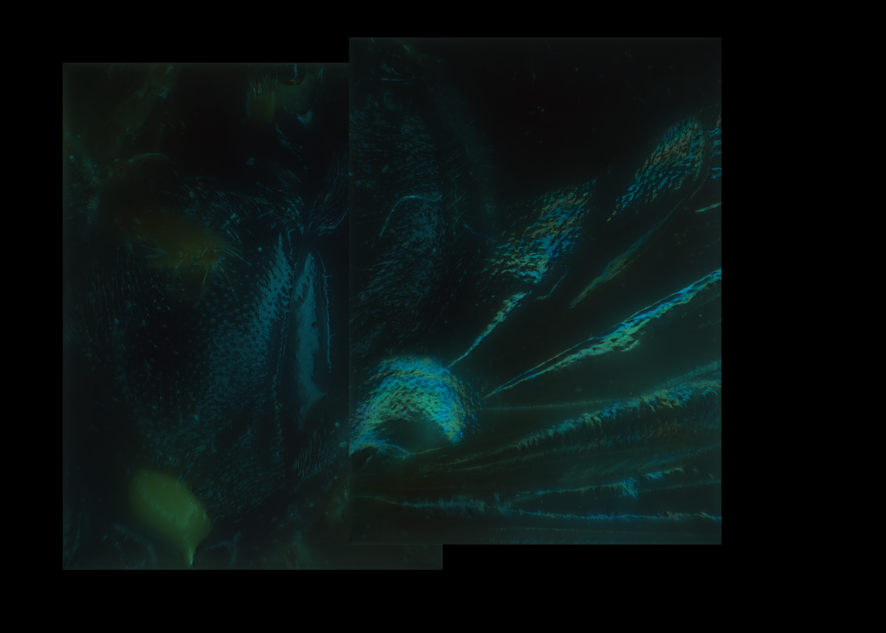

In [454]:
offset = 500
farr = zeros((w+offset,2*h+offset, 3))

#x, y = -14, 60

start = trunc(Int,offset/2)
rem_border = 15
farr[start:start-1+w, start:start-1+h, 1:end] = img1
farr[start+x:start-1+x+w, start+y+trunc(Int,(1-overlap)*h)+rem_border:start-1+y+trunc(Int,(2-overlap)*h)-rem_border, 1:end] = img2[1:end, 1+rem_border:end-rem_border,:]

farr= permutedims(farr .* 2, (3,1,2))
farr = Images.colorview(Images.RGB,farr)

IJulia.display(farr)

In [478]:
tmp1 = img2[1:2008, 1:284, :]
pt1 = argmax(Statistics.mean(tmp1,dims=3))
i,j = Tuple(pt1)
tmp1[i,j,:] = [1,0,0]
tmp2 = img1[1:2008, 1217:1500,:];
pt2 = argmax(Statistics.mean(tmp2,dims=3))
i,j = Tuple(pt2)
tmp2[i,j,:] = [1,0,0]

3-element Vector{Int64}:
 1
 0
 0

In [479]:
pt1

CartesianIndex(1371, 267, 1)

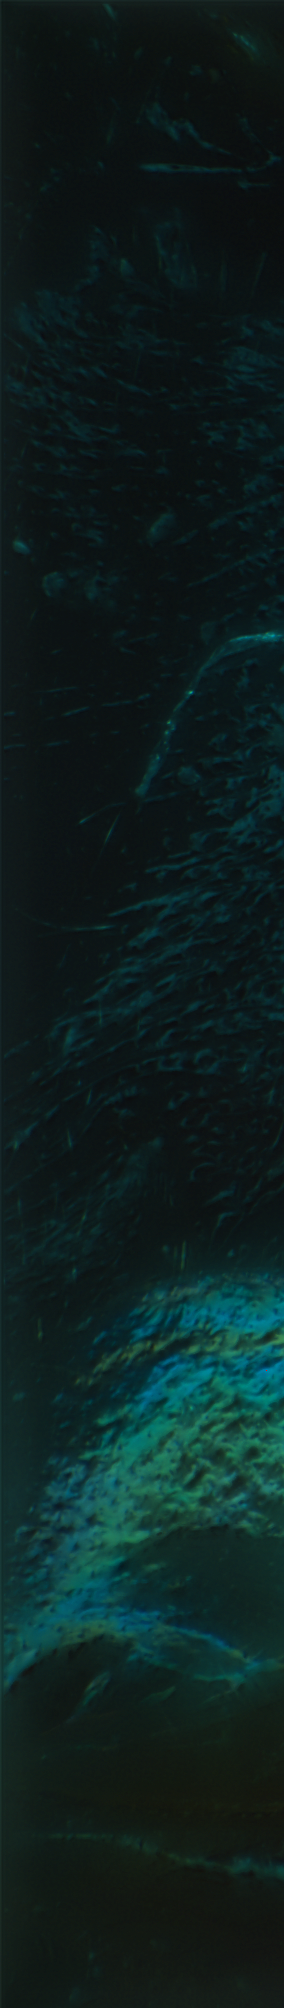

In [480]:
tmp1= permutedims(tmp1 .* 2, (3,1,2))
tmp1 = Images.colorview(Images.RGB,tmp1)
IJulia.display(tmp1)

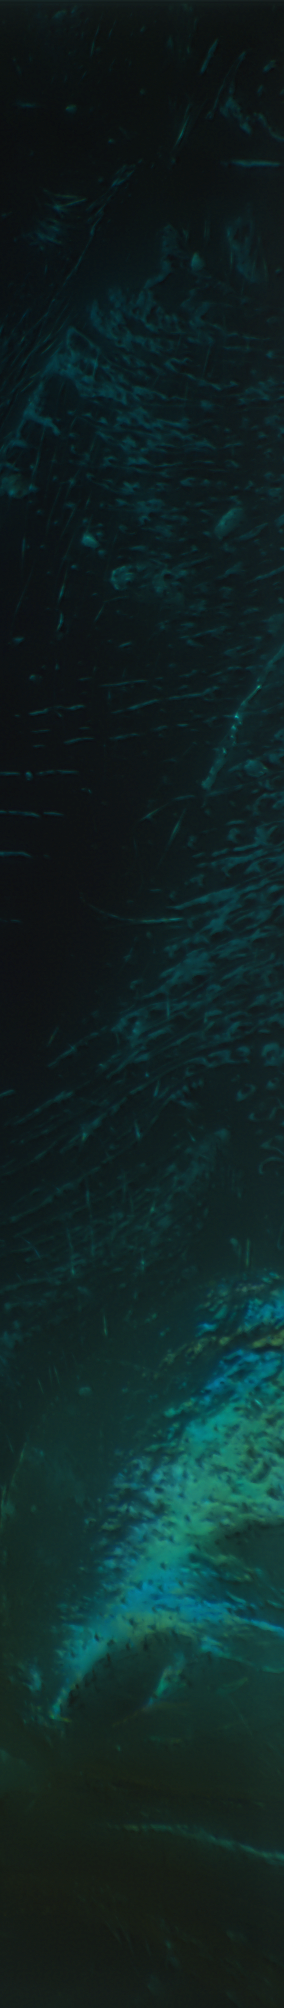

In [467]:
tmp1= permutedims(tmp2 .* 2, (3,1,2))
tmp1 = Images.colorview(Images.RGB,tmp1)
IJulia.display(tmp1)